# CASE COMPETITION

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Convert to categorical variables
train_df['AI_Response_Time'] = train_df['AI_Response_Time'].astype('category')
train_df['Customer_Churn'] = train_df['Customer_Churn'].astype('category')
train_df['AI_Interaction_Level'] = train_df['AI_Interaction_Level'].astype('category')
train_df['Change_in_Usage_Patterns'] = train_df['Change_in_Usage_Patterns'].astype('category')
 
test_df['AI_Response_Time'] = test_df['AI_Response_Time'].astype('category')
test_df['Customer_Churn'] = test_df['Customer_Churn'].astype('category')
test_df['AI_Interaction_Level'] = test_df['AI_Interaction_Level'].astype('category')
test_df['Change_in_Usage_Patterns'] = test_df['Change_in_Usage_Patterns'].astype('category')

# Check the updated data types
print("Updated data types in the train dataset:")
print(train_df.dtypes)

Updated data types in the train dataset:
ID                                     int64
Age                                    int64
AI_Interaction_Level                category
Satisfaction_with_AI_Services          int64
AI_Personalization_Effectiveness       int64
AI_Response_Time                    category
Overall_Usage_Frequency                int64
Customer_Service_Interactions          int64
Change_in_Usage_Patterns            category
Customer_Churn                      category
dtype: object


In [4]:
# Split the data into features and target variable
X_train = train_df.drop(columns=['ID', 'Customer_Churn'])
y_train = train_df['Customer_Churn']
X_test = test_df.drop(columns=['ID', 'Customer_Churn'])
y_test = test_df['Customer_Churn']

# Scale the numeric columns
numeric_cols = ["Age", "Satisfaction_with_AI_Services", "AI_Personalization_Effectiveness",
                "Overall_Usage_Frequency",
                "Customer_Service_Interactions"]
numeric_transformer = StandardScaler()

# Fit and transform the training data
X_train_scaled = numeric_transformer.fit_transform(X_train[numeric_cols])
# Convert the scaled data back to a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)

# Transform the test data
X_test_scaled = numeric_transformer.transform(X_test[numeric_cols])
# Convert the scaled data back to a DataFrame
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

# Update the original DataFrames with the scaled data
for col in numeric_cols:
    X_train[col] = X_train_scaled[col]
    X_test[col] = X_test_scaled[col]

# Now you can access the column names
print(X_train.columns)


Index(['Age', 'AI_Interaction_Level', 'Satisfaction_with_AI_Services',
       'AI_Personalization_Effectiveness', 'AI_Response_Time',
       'Overall_Usage_Frequency', 'Customer_Service_Interactions',
       'Change_in_Usage_Patterns'],
      dtype='object')


In [5]:
X_train.head()

,Age,AI_Interaction_Level,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,AI_Response_Time,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns
0,1.308417,2,0.520010,0.511193,2,0.285562,-0.020830,2
1,0.511816,2,0.170870,-0.182326,1,-1.438151,-0.964795,0
2,-0.603425,2,-0.876553,-0.875846,3,-0.863580,-0.964795,1
3,1.627057,2,-0.876553,-0.875846,2,-1.093408,0.293825,2
4,-1.161045,4,0.170870,0.164434,1,-0.518837,-0.650140,-1


# Full Random Model

In [6]:
# FullRandom Forest model
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6496


# Feature selection

In [8]:
importances = rf_model.feature_importances_

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                            Feature  Importance
0                               Age    0.212680
5           Overall_Usage_Frequency    0.206696
6     Customer_Service_Interactions    0.149664
2     Satisfaction_with_AI_Services    0.105723
3  AI_Personalization_Effectiveness    0.100044
7          Change_in_Usage_Patterns    0.093539
1              AI_Interaction_Level    0.072869
4                  AI_Response_Time    0.058786


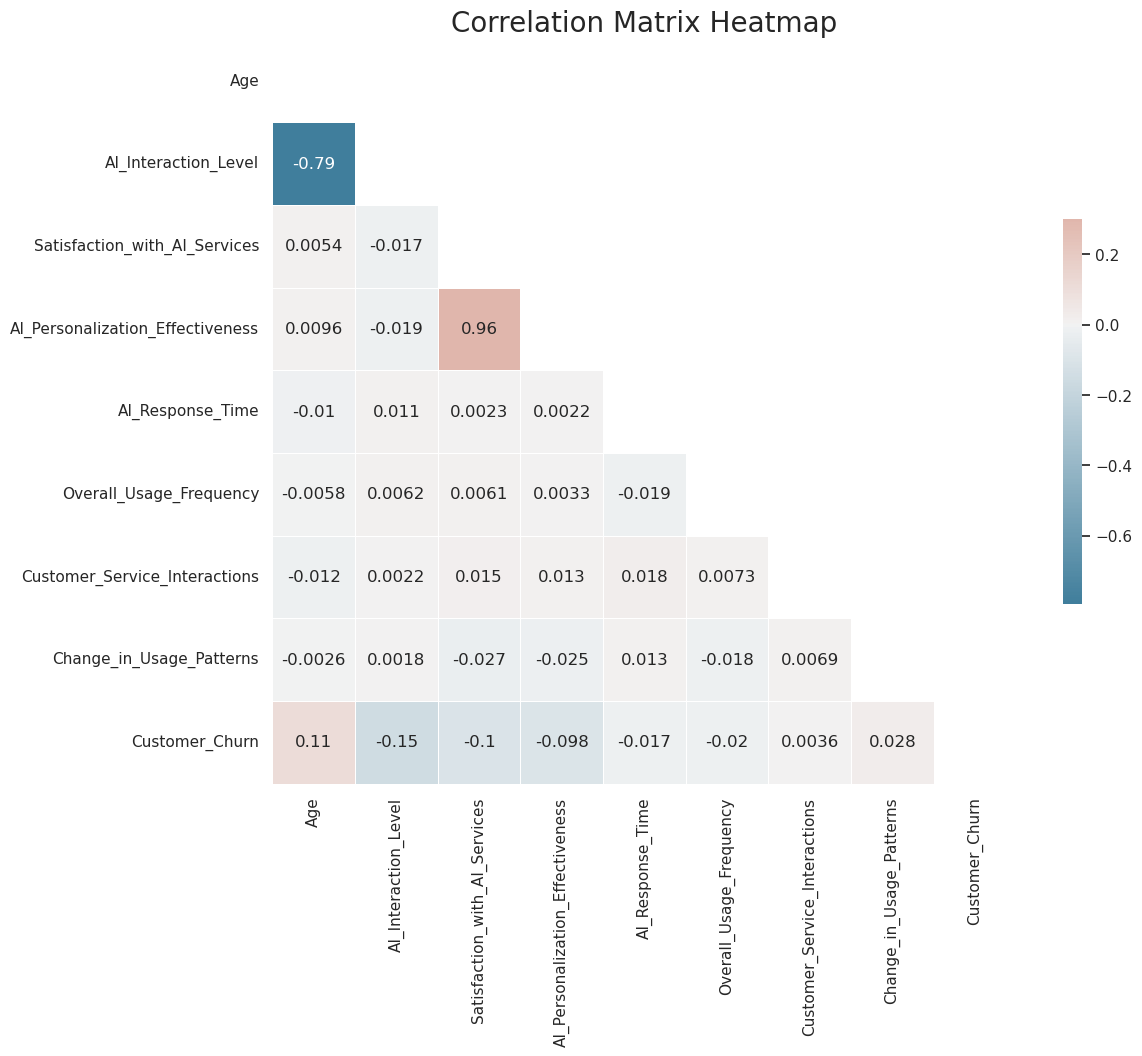

In [9]:
#Correlation matrix, excluding the 'ID' column

df = pd.read_csv('train.csv')
corr = df.drop(columns=['ID']).corr()

# Set up
sns.set(style="white")
plt.figure(figsize=(12, 10))

# Mask the upper triangle so no duplicate correlation will be shown
mask = np.triu(np.ones_like(corr, dtype=bool))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Plot result
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.show()

**We remove 1 variable, 'AI_Interaction_Level' because it has a high negative correlation AND 'AI_Interaction_Level rank quite low in feature importance**

In [10]:
#Drop 1 variable because high correlation, and between the two AI_Interaction_Level less important
X_train_reduced = X_train.drop('AI_Interaction_Level', axis=1)
X_test_reduced = X_test.drop('AI_Interaction_Level', axis=1)

In [11]:
# Retrain the model with the reduced train set
rf_model_reduced = RandomForestClassifier(random_state=123)
rf_model_reduced.fit(X_train_reduced, y_train)

# Evaluate the model with the reduced test set
y_pred_reduced = rf_model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print("Accuracy with reduced test set:", accuracy_reduced)

Accuracy with reduced test set: 0.6592


## Hypertuning parameters

**Do not run the first chunk of code below this, it will take about 15 minutes!** It's using grid search to select the best tuning parameters, we found max_features: 1, n_estimators: 200 to give the best results

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [None, 2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [None, 1, 2, 4], # Minimum number of samples required to be at a leaf node
    'max_features': [1,2,3]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=123)

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_reduced, y_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

In [12]:
# Retrain the model with the tunedpreduced train set
rf_model_reduced_tuned = RandomForestClassifier(random_state=123, n_estimators=200, max_features=1)
rf_model_reduced_tuned.fit(X_train_reduced, y_train)

# Evaluate the model with the tuned-reduced test set
y_pred_reduced_tuned = rf_model_reduced_tuned.predict(X_test_reduced)
accuracy_reduced_tuned = accuracy_score(y_test, y_pred_reduced_tuned)
print("Accuracy with reduced and tuned test set:", accuracy_reduced_tuned)

Accuracy with reduced and tuned test set: 0.716


## Conclusion

Best model: Random Forest -> feature selection (remove 'AI_Interaction_Level' due to importance and correlation) -> find the best tuning parameter
Accuracy: 0.717

In [13]:
results_df=pd.DataFrame({'ID': test_df['ID'], 'Prediction': y_pred_reduced_tuned})
results_df.to_csv('results.csv', index=False)